# The Daring Landscape of Probability Distribution Functions

Once you start venturing past the safe havens of the normal distribution, things can start looking scary quickly.
To try to grant you safe passage, this post will provide a coarse map of the distribution landscape which can be obtained from [Wikipedia](https://en.wikipedia.org/wiki/List_of_probability_distributions).

It will attempt to do so by creating a network of probabilistic distributions where each node corresponds to such a distribution and an edge is drawn
from one node to another if they are "related".
As a heuristic for determining whether distribution $D_1$ is related to $D_2$ we take the binary observation whether $D_2$ is mentioned in the summary of $D_1$ on Wikipedia.

In [1]:
import re

import pandas as pd

import requests
import wikipediaapi
from bs4 import BeautifulSoup

import graphviz
import networkx as nx

import seaborn as sns

from tqdm.auto import tqdm

In [2]:
DISTRIBUTION_BLACKLIST = [
    'probability distribution',
    'continuous probability distribution',
    'discrete probability distribution',
]

## Obtaining distribution associations from Wikipedia

To create the distribution map, we first obtain the [list of all "known" probability distributions](https://en.wikipedia.org/wiki/List_of_probability_distributions) from Wikipedia.
Subsequently, we link distributions if they mention each other in their respective article summaries.

The `wikipedia-api` Python package sadly does not allow to extract hyperlinks from the summary of an article only.
This leads to many false positives as very often a whole bunch of not quite directly related distributions are mentioned in the appendix of an article.
In particular, the `link` property of a `page` object returns links from the whole page, and the `summary` property strips away the metainformation of what is a link and what is not.
<!--Additionally, this gives us the flexibility to apply more complex exclusion patterns such as, for example, excluding entries which end with the suffix "family" even if it is not contained in the link title.-->

So we have to write our own custom crawler instead.

In [3]:
wiki = wikipediaapi.Wikipedia('en', extract_format=wikipediaapi.ExtractFormat.HTML)

In [4]:
def get_related_distributions(distribution_name, verbose=False):
    if verbose:
        print(f'=== {distribution_name} ===')

    # retrieve page source
    page = wiki.page(distribution_name)
    if not page.exists():
        return []

    resp = requests.get(page.fullurl)
    soup = BeautifulSoup(resp.text, 'html.parser')

    # find main content
    res = soup.find_all('div', attrs={'class': 'mw-parser-output'})
    assert len(res) == 1
    main_content = res[0]

    # extract links in summary
    link_set = set()
    have_observed_table = False
    for child in main_content.children:
        if verbose:
            print(child)
            print('-' * 80)

        if child.name == 'table':
            # this makes sure we don't break immediately if the first child is a div (e.g. containing "For other uses, see [...]")
            have_observed_table = True
        if child.name == 'p':
            tmp = [
                link.attrs['title'].lower()
                for link in child.find_all('a')
                if 'title' in link.attrs
                and link.attrs['title'].lower().endswith('distribution')
            ]
            link_set.update(tmp)
        if child.name == 'div' and have_observed_table:
            break

    return sorted(link_set)

In [5]:
# at a later point we might be interested in obtaining detailed information about each distribution
# unfortunately, many math notation blocks are images and not text...

# table_list = pd.read_html(wiki.page('Bernoulli distribution').fullurl, match='Parameters')
# assert len(table_list) == 1

# df_overview = table_list[0]
# df_overview

In [6]:
# obtain list of all distributions
page = wiki.page('List of probability distributions')
all_distribution_links = page.links

# extract distribution mentions
distribution_linkages = {}
for title in tqdm(all_distribution_links):
    if not title.endswith('distribution'):
        continue

    related_distributions = get_related_distributions(title)
    distribution_linkages[title.lower()] = related_distributions

  0%|          | 0/561 [00:00<?, ?it/s]

In [7]:
# briefly check data
distribution_linkages['beta distribution']

['bernoulli distribution',
 'beta prime distribution',
 'binomial distribution',
 'conjugate prior distribution',
 'dirichlet distribution',
 'geometric distribution',
 'negative binomial distribution',
 'probability distribution']

## Investigating the distribution network

As a proxy for the global importance of a distribution we are going to use its relatedness to other distributions.
The more other distributions it is related to, the more important we assume it is.

In graph theoretical terms this means that a higher node degree indicates higher importance, and we deem hubs as particularly important.

In [8]:
nx_graph = nx.DiGraph(
    [
        (source, target)
        for source, target_list in distribution_linkages.items()
        for target in target_list
        if source not in DISTRIBUTION_BLACKLIST and target not in DISTRIBUTION_BLACKLIST
    ],
    name='DistributionLandscape',
)
print(nx.info(nx_graph))

Name: DistributionLandscape
Type: DiGraph
Number of nodes: 233
Number of edges: 460
Average in degree:   1.9742
Average out degree:   1.9742


In [9]:
df_degree = (
    pd.concat(
        [
            pd.DataFrame(nx_graph.degree, columns=['node', 'degree']).set_index('node'),
            pd.DataFrame(nx_graph.in_degree, columns=['node', 'in_degree']).set_index(
                'node'
            ),
            pd.DataFrame(nx_graph.out_degree, columns=['node', 'out_degree']).set_index(
                'node'
            ),
        ],
        axis=1,
    )
    .sort_values('degree', ascending=False)
    .reset_index()
)

df_degree = df_degree[~df_degree['node'].isin(DISTRIBUTION_BLACKLIST)]

df_degree.head()

,node,degree,in_degree,out_degree
0,normal distribution,53,49,4
1,exponential distribution,22,17,5
2,beta distribution,22,15,7
3,gamma distribution,20,16,4
4,pearson distribution,19,4,15


[Text(0.5, 0, 'Node degree')]

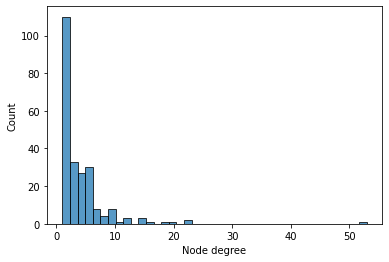

In [10]:
ax = sns.histplot(data=df_degree, x='degree')
ax.set(xlabel='Node degree')

We can observe that most distributions are related to less than $10$ other distributions and that there is one especially strong hub.
This hub is the good old normal distribution.

It is furthermore interesting to differentiate between high in- and high out-degrees, corresponding to distributions which are mentioned by many other and distributions which themselves mention many other distributions respectively.

In [11]:
# distributions which are mentioned by many others
df_degree.sort_values('in_degree', ascending=False).head()

,node,degree,in_degree,out_degree
0,normal distribution,53,49,4
1,exponential distribution,22,17,5
3,gamma distribution,20,16,4
2,beta distribution,22,15,7
6,multivariate normal distribution,15,14,1


In [12]:
# distributions which mention many others
df_degree.sort_values('out_degree', ascending=False).head()

,node,degree,in_degree,out_degree
5,generalized normal distribution,16,0,16
4,pearson distribution,19,4,15
7,metalog distribution,14,2,12
11,compound poisson distribution,12,2,10
17,beta-binomial distribution,9,1,8


## Plotting the distribution network

As the whole distribution network is quite large ($233$ nodes and $460$ edges) we will look at various subsets of it.
You can see the whole network at the end of the post.

In [13]:
def plot_network(node_selection, **graph_attr):
    graph = graphviz.Digraph(
        engine='dot', graph_attr=dict(ratio=str(9 / 16), **graph_attr)
    )

    # do not forget possibly isolated nodes
    for node in node_selection:
        graph.node(node)

    # add edges
    for source, target_list in distribution_linkages.items():
        if source not in node_selection:
            continue

        for target in target_list:
            if target not in node_selection:
                continue

            graph.edge(source, target)

    return graph

Including only nodes with degrees higher than $10$ yields a clear view of the most common distributions and how they relate to each other.

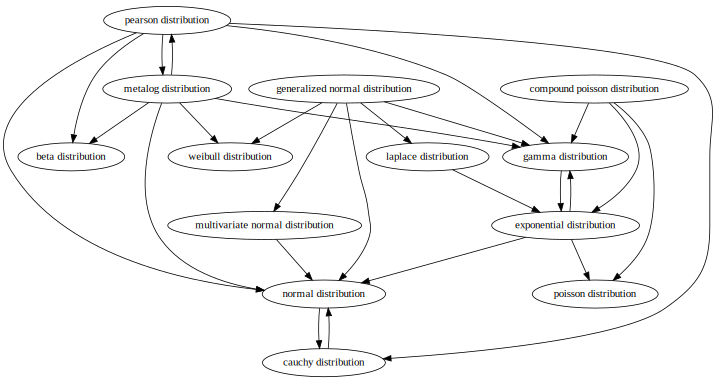

In [14]:
node_selection = df_degree.loc[df_degree['degree'] > 10, 'node'].tolist()
plot_network(node_selection, size='10')

Lowering the degree threshold to $5$ reveals the more complicated nature of the distribution landscape.

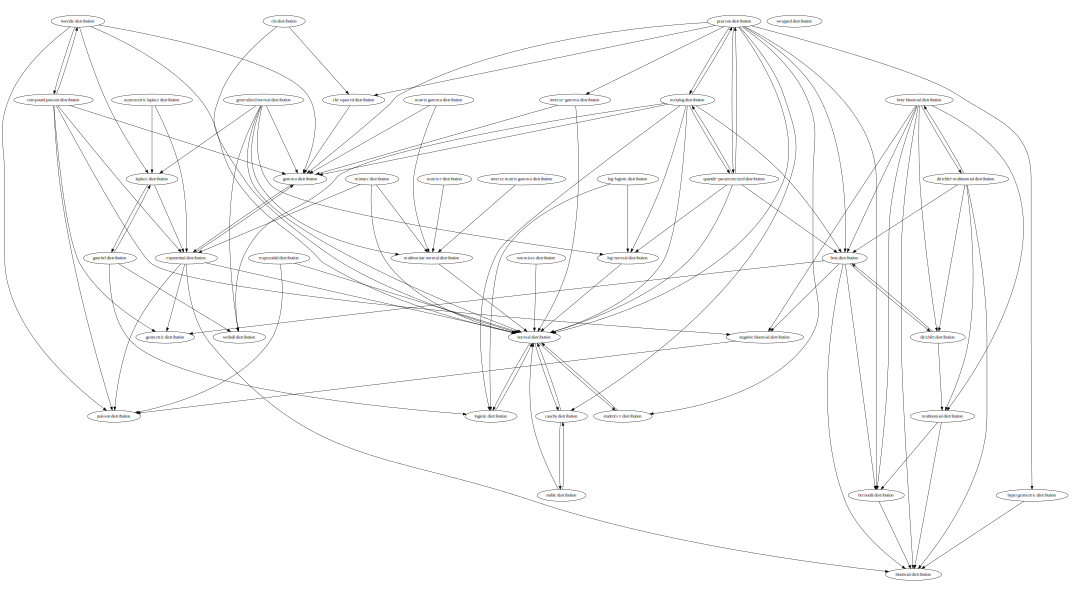

In [15]:
node_selection = df_degree.loc[df_degree['degree'] > 5, 'node'].tolist()
plot_network(node_selection, size='15')

Finally, removing the degree threshold let's us admire the unvarnished beauty of the universe in its entirety...

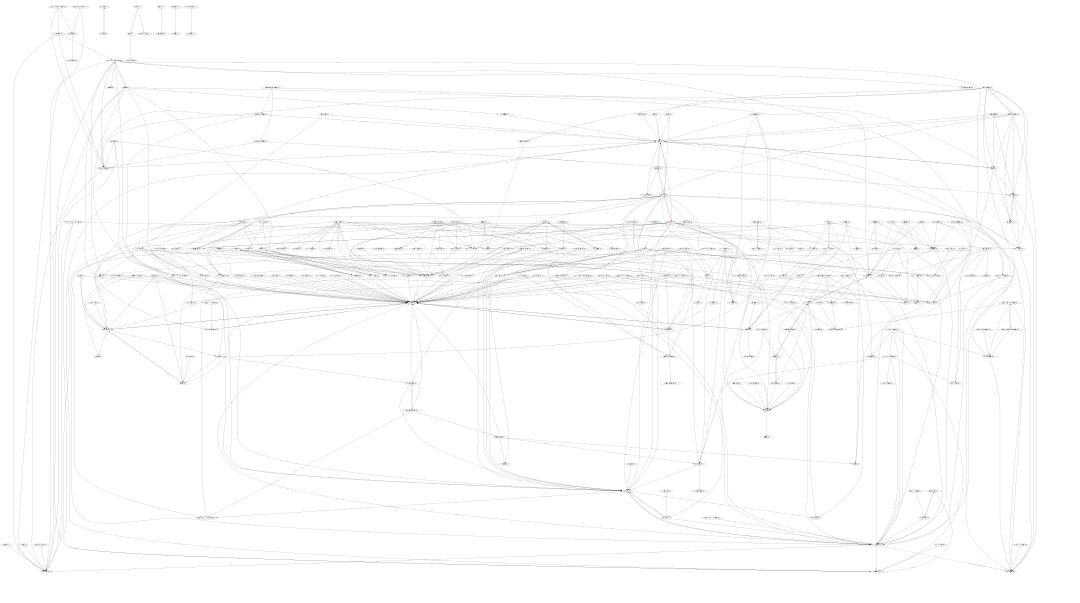

In [16]:
node_selection = df_degree['node'].tolist()

graph = plot_network(node_selection, size='15')
graph

In [17]:
# save the whole network for posterity
graph.render('distribution_landscape', view=False, cleanup=True)

'distribution_landscape.pdf'